<a href="https://colab.research.google.com/github/AliCollins/AliCollins.github.io/blob/master/AutoGluonEngD2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Attempting to use AutoGluon to give some understanding of what is happening in the wet gas dataset.  If I train on all the data except meter ??, do I get an accurate output on meter ???.

In [11]:
# # Uninstall mkl for faster neural-network training time
# !pip uninstall -y mkl
# # Upgrade pip to ensure the latest package versions are available
# !pip install -U pip
# !pip install -U "mxnet<2.0.0"
# !pip install autogluon
# !pip install -U ipykernel

In [12]:
import autogluon as ag
from autogluon.tabular import TabularDataset, TabularPredictor

Load in the data

In [13]:
# Load the Drive helper and mount
from google.colab import drive
import pandas as pd
import numpy as np

In [156]:
# raw_data = pd.read_excel("/content/drive/MyDrive/EngD/3 Venturi for Matlab.xlsx")
all_data = pd.read_excel("/content/drive/MyDrive/EngD/Dualstream WGC Database for EngD.xlsx", sheet_name=None) # Pulls in all the sheets of data
# Create the data frame
# df = pd.DataFrame(data=raw_data, )
df = pd.DataFrame(data=all_data.get("WETGAS"), )
df = df[df['WET_POINT_ID'].apply(lambda x: isinstance(x, (int, np.int64)))] # remove rows where WET_POINT_ID is not an integer value

# Setup the meters DataFrame from which to get the dimensional data
meters = all_data.get("METERS")
meters = meters[['METER_ID','PIPE_DIAMETER','ORIFICE_DIAMETER','MATERIAL_TE','BETA_VENTURI']]
meters = meters.rename(columns={'PIPE_DIAMETER': 'D', 'ORIFICE_DIAMETER': 'd', 'MATERIAL_TE': 'TE', 'BETA_VENTURI': 'Beta'})

df = pd.merge(df, meters, how="left", on=["METER_ID"])  # Merging the dimensional data (D, d, TE) into the df dataframe - D and d in mm

# Rename columns
df.rename(columns={'TEST_Qmg': 'Qmg', 'TEST_Qmc': 'Qmc', 'TEST_Qmw': 'Qmw'}, errors='raise', inplace='True')
df.rename(columns={'SISA_P': 'Press', 'SISA_T': 'Temp', 'SISA_RHOG': 'RhoG', 'SISA_RHOC': 'RhoC', 'SISA_RHOW': 'RhoW'}, errors='raise', inplace='True')
df.rename(columns={'SISA_GAS_VISCOSITY': 'Visc', 'SISA_GAS_IE': 'IE', 
                   'SISA_DPv_Hi': 'DPvH', 'SISA_DPv_Lo': 'DPvL', 
                   'SISA_DPt_Hi': 'DPtH', 'SISA_DPt_Lo': 'DPtL',
                   'SISA_DPv_INUSE': 'DPv', 'SISA_DPt_INUSE': 'DPt'}, errors='raise', inplace='True')

# Converting inputs to float types (rather than objects)
df['Qmg'] = df['Qmg'].astype(float)
df['Qmc'] = df['Qmc'].astype(float)
df['Qmw'] = df['Qmw'].astype(float)
df['RhoG'] = df['RhoG'].astype(float)
df['RhoC'] = df['RhoC'].astype(float)
df['RhoW'] = df['RhoW'].astype(float)
df['Visc'] = df['Visc'].astype(float)
df['IE'] = df['IE'].astype(float)
df['Press'] = df['Press'].astype(float)
df['Temp'] = df['Temp'].astype(float)
df['DPv'] = df['DPv'].astype(float)
df['DPt'] = df['DPt'].astype(float)

# Set Qmw to zero for two test points (WET_POINT_ID 871 and 884) are dry gas with tiny non-zero water flow rate.
df.loc[df.WET_POINT_ID == 871, 'Qmw'] = 0.0
df.loc[df.WET_POINT_ID == 884, 'Qmw'] = 0.0

# Extra parameters:

# Add meter constants (later merge with "meters" table as per PLR1)
# d = 68.46       # Throat diameter (mm) at 20 DegC
# D = 124.29      # Pipe diameter (mm) at 20 DegC
# TE = 0.0000173  # Thermal expansion coefficient ()
# Beta = d / D
# df['d'] = 68.46       # Throat diameter (mm) at 20 DegC
# df['D'] = 124.29      # Pipe diameter (mm) at 20 DegC
# df['TE'] = 0.0000173  # Thermal expansion coefficient ()
df['Beta'] = df['d'] / df['D']
# # Pipe Diameter (in m) allowing for thermal expansion
# # df['DatT'] = D / 1000.0 * (1.0 + (df['Temp'] - 20.0) * TE) 
df['DatT'] = df['D'] / 1000.0 * (1.0 + (df['Temp'] - 20.0) * df['TE'])
# # Pipe area (in m^2) at line temperature
df['Area'] = df['DatT'] * df['DatT'] * np.pi / 4.0

# Gas Mass Fraction
df['GMF'] = df['Qmg']  / (df['Qmg'] + df['Qmc'] + df['Qmw'])
# Superficial gas velocity (in m/s)
df['vsg'] = df['Qmg'] / df['RhoG'] / df['Area']
# Liquid Mass Density (kg/m3)
df['RhoL'] = (np.where((df['Qmw'] + df['Qmc']) > 0.0, (df['Qmw'] + df['Qmc']) / ((df['Qmw'] / df['RhoW']) + (df['Qmc'] / df['RhoC'])), 800.0))
# Water Liquid (volume) Ratio
df['WLR'] = np.where(((df['Qmw'] + df['Qmc']) > 0.0) & (df['RhoW'] > 0.0) & (df['RhoC'] > 0.0), (df['Qmw'] / df['RhoW']) / ((df['Qmw'] / df['RhoW']) + (df['Qmc'] / df['RhoC'])), 0.0)
# Densimetric Froude Gas number
df['Frg'] = df['vsg'] / np.sqrt(9.8065 * df['DatT']) * np.sqrt(df['RhoG'] / (df['RhoL'] - df['RhoG']))
# (simplified) Lockhart-Martinelli number
df['X'] = (df['Qmc'] + df['Qmw']) / df['Qmg'] * np.sqrt(df['RhoG'] / df['RhoL'])
# Tau (P2 / P1)
df['Tau'] = (df['Press'] - (df['DPv'] / 1000.0)) / df['Press']
# DR (RhoG/RhoL)
df['DR'] = df['RhoG'] / df['RhoL']
# CGMR (Qmc / Qmg)
df['CGMR'] = df['Qmc'] / df['Qmg']
# PLR (DPt / DPv)
df['PLR'] = df['DPt'] / df['DPv']

# Calculate Venturi expansibility coefficient
df['ExpA'] = df['IE'] * np.power(df['Tau'], 2.0 / df['IE']) / (df['IE'] - 1.0)
df['ExpB'] = (1.0 - np.power(df['Beta'], 4.0)) / (1.0 - np.power(df['Beta'], 4.0) * np.power(df['Tau'], 2.0 / df['IE']))
df['ExpC'] = (1.0 - np.power(df['Tau'], (df['IE'] - 1.0)/df['IE'])) / (1.0 - df['Tau'])
df['Exp'] = np.sqrt(df['ExpA'] * df['ExpB'] * df['ExpC'])

df['Qgmia'] = 1.0 / np.sqrt(1.0 - np.power(df['Beta'], 4.0)) * df['Exp'] * df['Area'] * np.power(df['Beta'], 2) * np.sqrt(200.0 * df['DPv'] * df['RhoG'])
df['Cdv'] = np.where(df['GMF'] > 0.999, df['Qmg'] / df['Qgmia'], np.NaN)

# Calculate Cdv for each meter
df_dry = df[df['GMF'] > 0.999]
#df_dry.head()

# for each project ID, find the average Cdv
Cdv_avg = df_dry.groupby(['PROJECT_ID']).agg({'Cdv': ['mean']})
Cdv_avg = pd.DataFrame(Cdv_avg.to_records())
Cdv_avg.rename(columns={list(Cdv_avg)[1]:'Cdv_avg'}, errors='raise', inplace='True')

# Merge the average Cdv into the df dataframe
df = pd.merge(df, Cdv_avg, how="left", on=['PROJECT_ID'])

# Calculate remaining properties
df['Qgmi'] = df['Qgmia'] * df['Cdv_avg']

def WGCcalc(row):
  row['WGC'] = max(row['Qgmi'] / row['Qmg'], 1.0)
  return row

#df['WGC'] = df['Qgmi'] / df['Qmg']
df = df.apply(WGCcalc, axis=1)

# print(df.columns)

# Remove points that are outside the liquid "limits" of wet gas and/or PLR
df = df[df.X <= 0.3]
df = df[df.GMF >= 0.80]


print(df['METER_ID'].nunique())
print(df['PROJECT_ID'].nunique())
print(df['WET_POINT_ID'].nunique())

23
22
3554


In [165]:
# Select only required columns
# df = df[["DR", "DPv", "DPt", "Frg", "WLR", "X"]]
# df = df[["DPv", "PLR", "RhoG", "vsg", "WLR", "X"]]
df = df[["PLR", "RhoG", "Qgmi", "WLR", "D", "Beta", "X"]]
# print(df.columns)
df.head()

train_data = TabularDataset(df)
# subsample_size = 300
# df.sample(subsample_size, random_state=0)
train_data.head()

save_path = 'agModels-predictClass'  # specifies folder to store trained models
time_limit = 60 * 15 # time limit in seconds
# predictor = TabularPredictor(label='X', path=save_path).fit(train_data)
# predictor = TabularPredictor(label='X', path=save_path).fit(train_data, presets='best_quality') # TOOK ~20 times longer to run!
predictor = TabularPredictor(label='X', path=save_path).fit(train_data, presets='best_quality', time_limit=time_limit) # Add in time limit to reduce maximum run time

Beginning AutoGluon training ...
AutoGluon will save models to "agModels-predictClass/"
AutoGluon Version:  0.3.1
Train Data Rows:    3554
Train Data Columns: 6
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (0.09780256328496673, 0.0, 0.02341, 0.01984)
	If 'regression' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    11589.75 MB
	Train Data (Original)  Memory Usage: 0.17 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerat

[1000]	train_set's rmse: 0.00544925	valid_set's rmse: 0.00747102
[2000]	train_set's rmse: 0.00453233	valid_set's rmse: 0.00723404
[3000]	train_set's rmse: 0.00398703	valid_set's rmse: 0.00708125
[4000]	train_set's rmse: 0.00359067	valid_set's rmse: 0.00698546
[5000]	train_set's rmse: 0.00329741	valid_set's rmse: 0.00691976
[6000]	train_set's rmse: 0.00306034	valid_set's rmse: 0.00687466
[7000]	train_set's rmse: 0.00285924	valid_set's rmse: 0.00684758
[8000]	train_set's rmse: 0.0026931	valid_set's rmse: 0.0068023
[9000]	train_set's rmse: 0.00254417	valid_set's rmse: 0.00679398
[10000]	train_set's rmse: 0.00241166	valid_set's rmse: 0.00676168


	-0.0068	 = Validation score   (root_mean_squared_error)
	9.92s	 = Training   runtime
	0.84s	 = Validation runtime
Fitting model: LightGBM ...
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 0.00248468	valid_set's rmse: 0.00719022
[2000]	train_set's rmse: 0.00168878	valid_set's rmse: 0.00704892
[3000]	train_set's rmse: 0.00135558	valid_set's rmse: 0.00699807
[4000]	train_set's rmse: 0.00119802	valid_set's rmse: 0.0069822
[5000]	train_set's rmse: 0.00111882	valid_set's rmse: 0.006984


	-0.007	 = Validation score   (root_mean_squared_error)
	5.73s	 = Training   runtime
	0.22s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-0.0084	 = Validation score   (root_mean_squared_error)
	2.64s	 = Training   runtime
	0.2s	 = Validation runtime
Fitting model: CatBoost ...
	-0.0068	 = Validation score   (root_mean_squared_error)
	10.21s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-0.0078	 = Validation score   (root_mean_squared_error)
	1.34s	 = Training   runtime
	0.1s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	-0.0073	 = Validation score   (root_mean_squared_error)
	4.55s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: XGBoost ...
	-0.0076	 = Validation score   (root_mean_squared_error)
	1.14s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: NeuralNetMXNet ...
	-0.0072	 = Validation score   (root_mean_squared_error)
	51.2s	 = Training   runtime
	0.18s	 = Validation runtime
Fitti

In [166]:
test_data = TabularDataset(df) # Need to separate out data in future...but for now, how well will it do on the training dataset?
y_test = test_data['X']
test_data_nolab = test_data.drop(columns=['X'])  # delete label column to prove we're not cheating
# test_data_nolab.head()

# predictor = TabularPredictor.load(save_path)  # unnecessary, just demonstrates how to load previously-trained predictor from file
y_pred = predictor.predict(test_data_nolab)
# print("Predictions:  \n", y_pred)
perf = predictor.evaluate_predictions(y_true=y_test, y_pred=y_pred, auxiliary_metrics=True)

Evaluation: root_mean_squared_error on test data: -0.003748580675869404
	Note: Scores are always higher_is_better. This metric score can be multiplied by -1 to get the metric value.
Evaluations on test data:
{
    "root_mean_squared_error": -0.003748580675869404,
    "mean_squared_error": -1.4051857083501491e-05,
    "mean_absolute_error": -0.002111482836911924,
    "r2": 0.9642849083700704,
    "pearsonr": 0.9830407066673917,
    "median_absolute_error": -0.0011107080976909267
}


In [167]:
# print("AutoGluon infers problem type is: ", predictor.problem_type)
# print("AutoGluon identified the following types of features:")
# print(predictor.feature_metadata)

# predictor.leaderboard(test_data, silent=True)

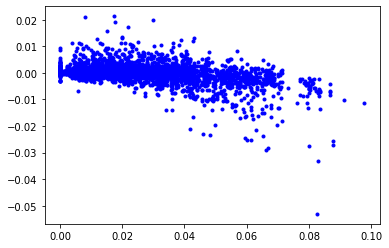

In [168]:
df['Pred'] = y_pred
df['Err'] = df['Pred'] - df['X']
df['PercentErr'] = df['Err'] / df['X']

import matplotlib.pyplot as plt
plt.plot(df.X, df.Err, 'b.')
plt.show()

# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# print(df)